# HW2: Model Explanability

## 1. Load data for modeling.  This data represents taxi rides in NY (from a Kaggle competition)

In [6]:
import math
import scipy
import warnings
import numpy as np
import pandas as pd
import matplotlib
import seaborn as sns
import xgboost as xgb
import matplotlib.pylab as plt

from sklearn.ensemble import RandomForestRegressor
from sklearn.neural_network import MLPRegressor
from sklearn.metrics import mean_squared_error, mean_absolute_error, median_absolute_error

matplotlib.use('nbagg');
warnings.filterwarnings("ignore");
%matplotlib inline

In [7]:
# Load the data into pandas dataframes
x_train = pd.read_parquet('data/x_train.parquet.gzip')
x_test = pd.read_parquet('data/x_test.parquet.gzip')
y_train = pd.read_parquet('data/y_train.parquet.gzip')
y_test = pd.read_parquet('data/y_test.parquet.gzip')

## 2. Model Build

### Random Forest Regression

In [8]:
regr_rf = RandomForestRegressor(max_features='sqrt', min_samples_leaf = 4,
    min_samples_split = 3, n_estimators = 40, n_jobs = -1)
regr_rf.fit(x_train, y_train)

RandomForestRegressor(max_features='sqrt', min_samples_leaf=4,
                      min_samples_split=3, n_estimators=40, n_jobs=-1)

In [9]:
y_train_pred_rf = regr_rf.predict(x_train)
mse_train_rf = mean_squared_error(y_train, y_train_pred_rf)

y_pred_rf = regr_rf.predict(x_test)
mse_rf = mean_squared_error(y_test, y_pred_rf)
print(mse_rf)

165.88746988422383


### XGboost Regression

In [10]:
regr_xgb = xgb.XGBRegressor(
    learning_rate=0.1, n_estimators=1000, max_depth=3, min_child_weight=3,
    gamma=0, subsample=0.8, reg_alpha=200, reg_lambda=200, colsample_bytree=0.8, n_jobs=-1
)
regr_xgb.fit(x_train, y_train)

XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=0.8, device=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, feature_types=None,
             gamma=0, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=0.1, max_bin=None,
             max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=3, max_leaves=None,
             min_child_weight=3, missing=nan, monotone_constraints=None,
             multi_strategy=None, n_estimators=1000, n_jobs=-1,
             num_parallel_tree=None, random_state=None, ...)

In [11]:
# Predicting on train & test data using our trained XgBoost regressor model
y_train_pred_xgb = regr_xgb.predict(x_train)
mse_train_xgb = mean_squared_error(y_train, y_train_pred_xgb)

y_pred_xgb = regr_xgb.predict(x_test)
mse_xgb = mean_squared_error(y_test, y_pred_xgb)

print(mse_xgb)

167.69782605118917


### Feed forward NN: MLP

In [12]:
regr_mlp = MLPRegressor(
        hidden_layer_sizes=[50, 25],
        activation='relu',
        solver='adam',
        early_stopping=True,
        random_state=33
)
regr_mlp.fit(x_train, y_train)

MLPRegressor(early_stopping=True, hidden_layer_sizes=[50, 25], random_state=33)

In [13]:
y_train_pred_mlp = regr_mlp.predict(x_train)
mse_train_mlp = mean_squared_error(y_train, y_train_pred_mlp)

y_pred_mlp = regr_mlp.predict(x_test)
mse_mlp = mean_squared_error(y_test, y_pred_mlp)
print(mse_train_mlp)
print(mse_mlp)

166.36158474862742
163.90548439517625


### Q1 (5pts): Which model is the most over-fit to its training data?

In [14]:
print("MSE")
print("rf train "+str(mse_train_rf))
print("rf test "+str(mse_rf))
print("Gap "+str(abs(mse_train_rf - mse_rf)))
print("====================================")
print("XGB train "+str(mse_train_xgb))
print("XGB test "+str(mse_xgb))
print("Gap "+str(abs(mse_train_xgb - mse_xgb)))
print("====================================")
print("NN MLP train "+str(mse_train_mlp))
print("NN MLP test "+str(mse_mlp))
print("Gap "+str(abs(mse_train_mlp - mse_mlp)))


MSE
rf train 83.17756708810155
rf test 165.88746988422383
Gap 82.70990279612228
XGB train 158.41149476074156
XGB test 167.69782605118917
Gap 9.286331290447606
NN MLP train 166.36158474862742
NN MLP test 163.90548439517625
Gap 2.456100353451177


We see that the model that is over fitting to the training data is the random forest model with a gap of 82 between the train and test mse

### Q2 (5pts): Is AUC an appropriate metric to evaluate these models?  Why or why not?

In [15]:
y_test.nunique()

target    367
dtype: int64

No our target variable is not binary and this is a regression problem. the use of AUC ROC is usually used for classification problems and not for regression. For regression models you would expect metrics like MSE RMSE MAE R2 adjusted R2... 

# Global Explanability

## Random Forest Feature Importance

### Q3 (5pts): Why is it important to look at the overall predictive power of a model before looking at feature importance for that model?

BC if the models performance / predictive power is at 50% or slightly over 50% it is no better than random chance.

It would not matter what features a model uses if it is no better than random chance.

### Q4 (5pts): How could you validate that these regression models are providing any predictive power at all? [you do not have to write code to answer this question]

In [16]:
def plot_feature_importance(importance,names,model_type):

    #Create arrays from feature importance and feature names
    feature_importance = np.array(importance)
    feature_names = np.array(names)

    #Create a DataFrame using a Dictionary
    data={'feature_names':feature_names,'feature_importance':feature_importance}
    fi_df = pd.DataFrame(data)

    #Sort the DataFrame in order decreasing feature importance
    fi_df.sort_values(by=['feature_importance'], ascending=False,inplace=True)

    #Define size of bar plot
    plt.figure(figsize=(10,8))
    #Plot Searborn bar chart
    sns.barplot(x=fi_df['feature_importance'], y=fi_df['feature_names'])
    #Add chart labels
    plt.title(model_type + ':  FEATURE IMPORTANCE')
    plt.xlabel('FEATURE IMPORTANCE')
    plt.ylabel('FEATURE NAMES')

In [17]:
def permutation_based_feature_importance(x_test, y_test, initial_mse, model):

    # Initialize an array to store feature importances
    feature_importances = np.zeros(x_test.shape[1])

    # Number of permutation iterations (you can adjust this value)
    num_iterations = 100

    # Calculate feature importance by permuting one feature at a time
    ####################### CODE HERE ############################
    for feature in range(x_test.shape[1]):
        print('Permuting feature ',feature + 1)
        # Copy the original test data
        x_test_permuted = x_test.copy()

        # Shuffle the values of the current feature
        permuted_column = x_test_permuted.iloc[:, feature]
        np.random.shuffle(permuted_column)
        x_test_permuted.iloc[:, feature] = permuted_column

        # Calculate the accuracy with the permuted feature
        permuted_mse = mean_squared_error(y_test, model.predict(x_test_permuted))

        # Calculate the drop in accuracy and store it as feature importance
        feature_importances[feature] = initial_mse - permuted_mse

    # Normalize the feature importances
    feature_importances /= feature_importances.sum()

    # Get the names of the features (assuming X is a DataFrame)
    feature_names = x_test.columns

    # Sort features by importance
    sorted_idx = np.argsort(feature_importances)

    return feature_importances[sorted_idx]

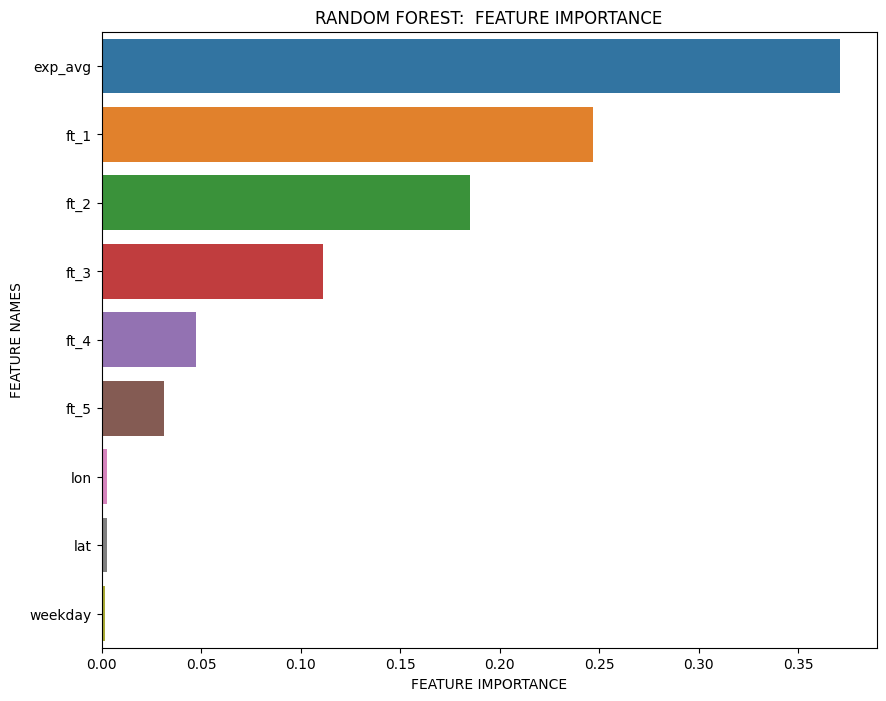

In [18]:
plot_feature_importance(regr_rf.feature_importances_,x_train.columns,'RANDOM FOREST')

In [19]:







permutation_based_feature_importance_rf = permutation_based_feature_importance(x_train, y_train, mse_train_rf, regr_rf)

Permuting feature  1
Permuting feature  2
Permuting feature  3
Permuting feature  4
Permuting feature  5
Permuting feature  6
Permuting feature  7
Permuting feature  8
Permuting feature  9


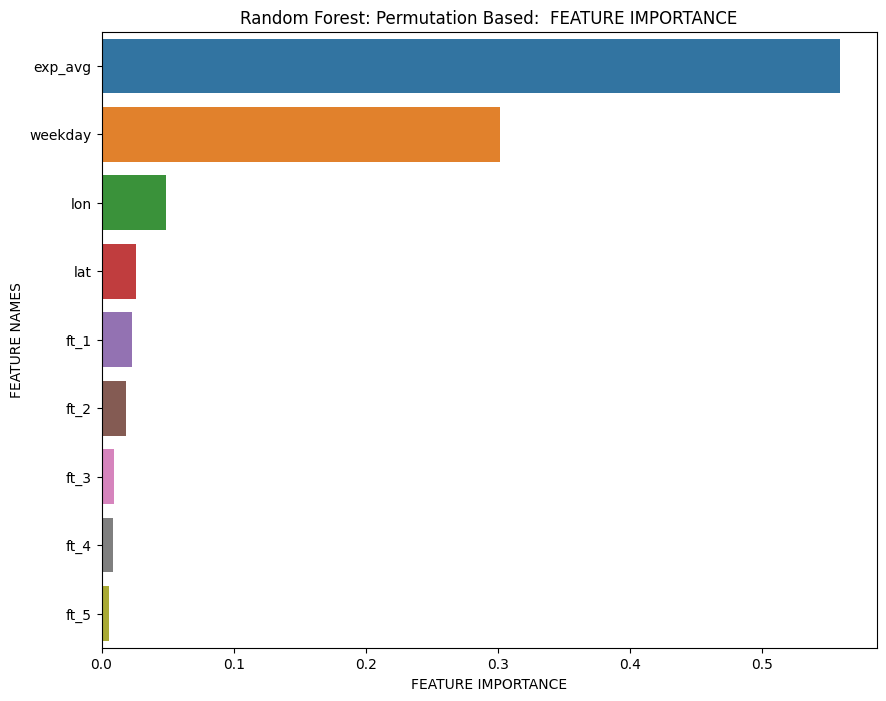

In [20]:
plot_feature_importance(permutation_based_feature_importance_rf,x_train.columns,'Random Forest: Permutation Based')

Permutation-based feature importance provides a straightforward and model-agnostic way to assess the significance of each feature in a predictive model. It assesses the impact of each feature on the model's performance by measuring how the model's accuracy or performance decreases when the values of a specific feature are randomly shuffled or permuted.

Based on the two feature importances above we see a random forests feature importance followed by a random forest permutation based feature importance
From the permutation feature importance we see the top 3 features are exp_avg weekday and lon from the randomforest model we are given we see it only share one top feature of exp_avg 
and lon and weekday are actually not very important in the prediction. 

I would say that this model has low predictive power due to the presence of only 1 top feature from the permutation based importance being amongst the top 3.
It should be mentioned that the performance of the model might be good but in terms of model interpretability the model performs poorly due to it using the wrong features



### Q5 (5pts): Is the `weekday` feature important to the `regr_rf` model?

No

### Q6 (5pts): Is the `weekday` feature important to predicting the target?

Yes

### Q7 (10pts): Is the `.feature_importances_` of the `regr_rf` model reliable?  Why or why not?  [hint](https://scikit-learn.org/stable/auto_examples/inspection/plot_permutation_importance.html)

No as stated in the link "Impurity-based feature importance can inflate the importance of numerical features. Furthermore, the impurity-based feature importance of random forests suffers from being computed on statistics derived from the training dataset: the importances can be high even for features that are not predictive of the target variable, as long as the model has the capacity to use them to overfit."

### Q8 (5pts): Are there any highly correlated features in this dataset?  Which ones?

   Feature           VIF
0    const  4.014975e+06
1     ft_5  2.378619e+01
2     ft_4  4.488765e+01
3     ft_3  1.644021e+02
4     ft_2  1.478866e+03
5     ft_1  1.605302e+04
6      lat  1.011390e+00
7      lon  1.013251e+00
8  weekday  1.000519e+00
9  exp_avg  3.227942e+04


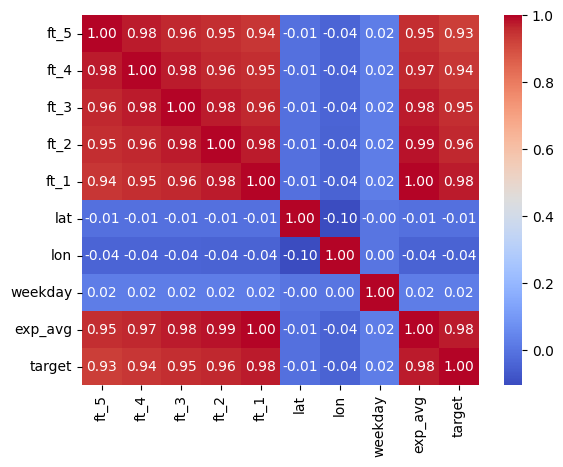

In [48]:
from statsmodels.stats.outliers_influence import variance_inflation_factor
from statsmodels.tools.tools import add_constant
# Merging x_train and y_train
train_data = pd.concat([x_train, y_train], axis=1)

# Merging x_test and y_test
test_data = pd.concat([x_test, y_test], axis=1)

# Combining train and test data
combined_data = pd.concat([train_data, test_data])

### CORRELATION MATRIX
# Calculating the correlation matrix
correlation_matrix = combined_data.corr()

# Visualizing the correlation matrix using a heatmap
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt=".2f")


#####VIF
# NOTE THIS IS ASSUMING ALL THE FEATURES PROVIDED IN THE DATASET IS INDEPENDANT !
independent_variables = combined_data.drop('target', axis=1)  # Drop the target column

# Adding a constant to the data for the intercept term
independent_variables = add_constant(independent_variables)

# Calculating VIF for each feature
vif_data = pd.DataFrame()
vif_data["Feature"] = independent_variables.columns
vif_data["VIF"] = [variance_inflation_factor(independent_variables.values, i) for i in range(independent_variables.shape[1])]

print(vif_data)

Based on the correlation heat map and the VIF calculation there are indeed highly correlated variables.

Specifically:

'exp_avg' 'ft_1', 'ft_2', 'ft_3', 'ft_4' 

### Q9 (5pts): What is the impact of highly correlated features on the analysis of feature importance for these models?

Highly correlated features can significantly impact the analysis of feature importance in predictive models. The presence of highly correlated features can affect the interpretation of feature importance.

As we can see the 5 variables listed above are the top 5 features in the normal random forest feature importanace. 

## Random Forest Feature Analysis

In [21]:
from sklearn.inspection import PartialDependenceDisplay

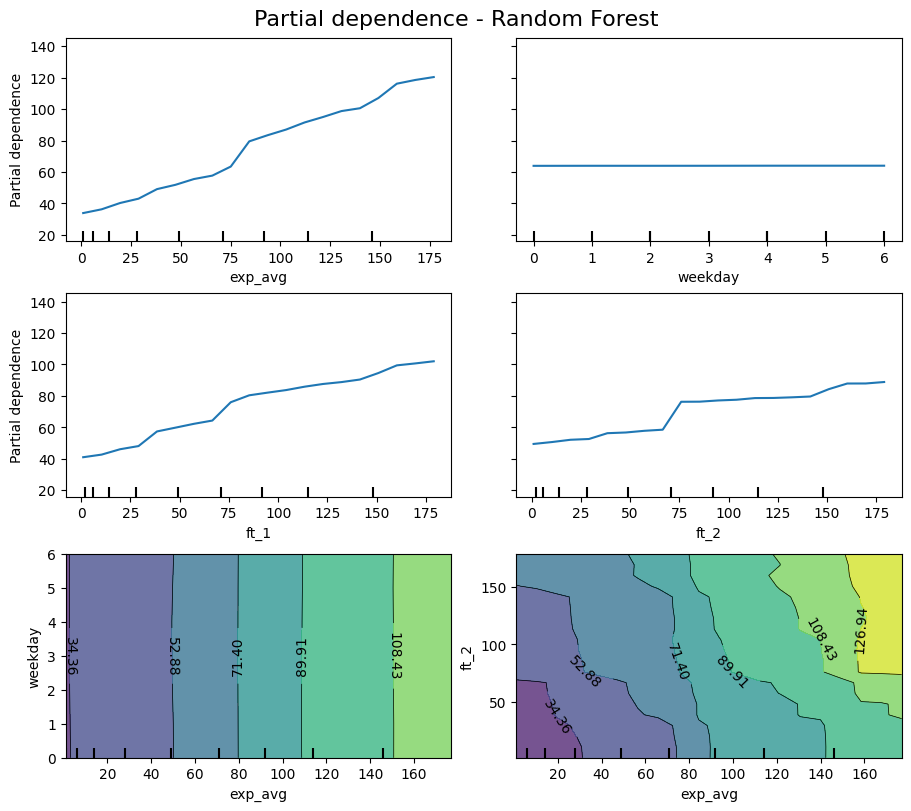

In [22]:
common_params = {
    "subsample": 50,
    "n_jobs": 2,
    "grid_resolution": 20,
    "random_state": 0,
}

features_info = {
    # features of interest
    "features": ["exp_avg", 'weekday', 'ft_1', 'ft_2', ("exp_avg", 'weekday'), ("exp_avg", 'ft_2')],
    # type of partial dependence plot
    "kind": "average"
}

_, ax = plt.subplots(ncols=2, nrows=3, figsize=(9, 8), constrained_layout=True)
display = PartialDependenceDisplay.from_estimator(
    regr_rf,
    x_train,
    **features_info,
    ax=ax,
    **common_params,
)

_ = display.figure_.suptitle(("Partial dependence - Random Forest"),fontsize=16)

### Q8 (5pts): Explain the partial dependence plot of 'exp_avg'.

PDP shows the marginal effect one or two features have on the predicted outcome of a machine learning model . A partial dependence plot can show whether the relationship between the target and a feature is linear, monotonic or more complex.

For exp_avg we see a monotonic relationship.


### Q9 (10pts): Is there any interaction between 'exp_avg' and 'weekday'? How about 'exp_avg' and 'ft_2'?


reading the two input PDP we see on the left (weekday and exp_avg) we see that exp _avg and weekday have no interactions between the two

Where as if you look to the right and see ft_2 and exp_avg we see that there is indded some interactions between ft_2 and exp_avg up to the ~90 point on exp_avg anything higher ft_2 no longer has any interactions with ft_2

In [23]:
# !pip install shap

In [24]:
import shap

In [25]:
explainer_rf = shap.Explainer(regr_rf, x_train)

In [26]:
shap_values_rf = explainer_rf(x_test[0:1000])

 99%|===================| 994/1000 [00:24<00:00]        

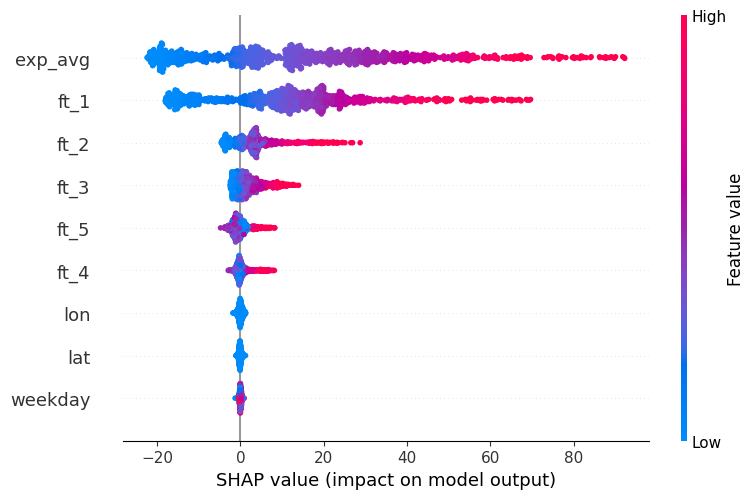

In [27]:
shap.summary_plot(shap_values_rf, x_test[0:1000])

### Q10 (5pts): Is `weekday` showing as an important factor on prediction explanations via SHAP?


No there is a low feature importance for weekday given the shap summary above

## XGBoost Feature Importance

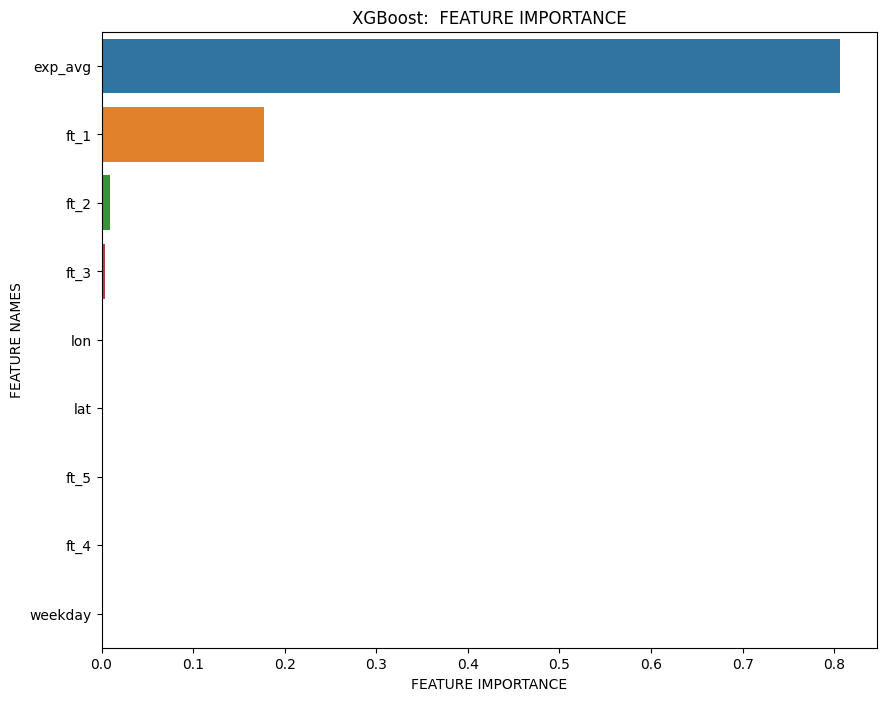

In [28]:
plot_feature_importance(regr_xgb.feature_importances_,x_train.columns,'XGBoost')

Permuting feature  1
Permuting feature  2
Permuting feature  3
Permuting feature  4
Permuting feature  5
Permuting feature  6
Permuting feature  7
Permuting feature  8
Permuting feature  9


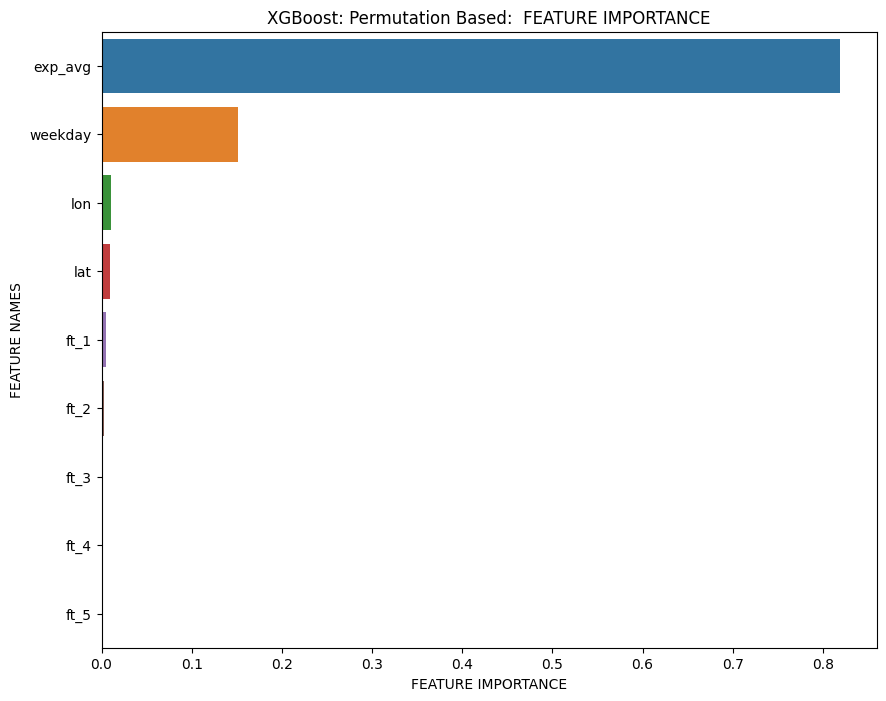

In [29]:
permutation_based_feature_importance_xgb = permutation_based_feature_importance(x_train, y_train, mse_train_xgb, regr_xgb)

plot_feature_importance(permutation_based_feature_importance_xgb,x_train.columns,'XGBoost: Permutation Based')

### Q11 (10pts): Based on the permutation-method feature importance chart for the XGBoost model, would you recommend that the model take out the less influential variables ft_1, ft_2, ft_3, ft_4, and ft_5 ?  Why or why not?


I would say it is ok to remove those features since they add little to the final prediction, But in this case specifically I would not remove them since having too little features can mean you are underfitting or introducing alot of bias into the model.

## XGBoost Feature Analysis

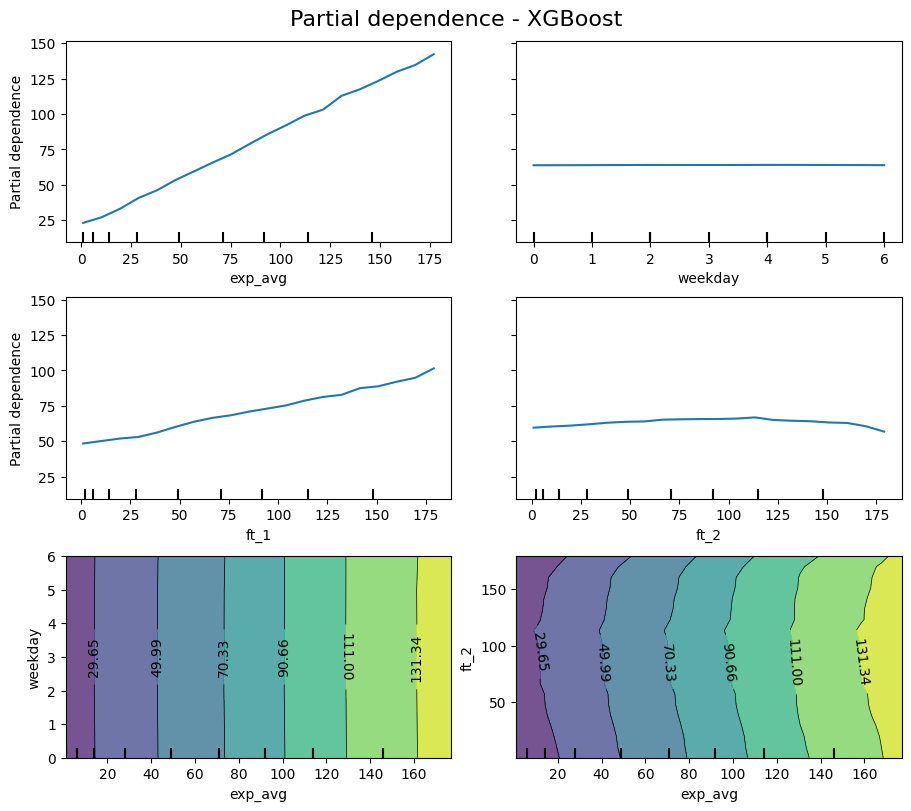

In [30]:
_, ax = plt.subplots(ncols=2, nrows=3, figsize=(9, 8), constrained_layout=True)
display = PartialDependenceDisplay.from_estimator(
    regr_xgb,
    x_train,
    **features_info,
    ax=ax,
    **common_params,
)

_ = display.figure_.suptitle(("Partial dependence - XGBoost"),fontsize=16)

In [31]:
explainer_xgb = shap.Explainer(regr_xgb, x_train)
shap_values_xgb = explainer_xgb(x_test[0:100])

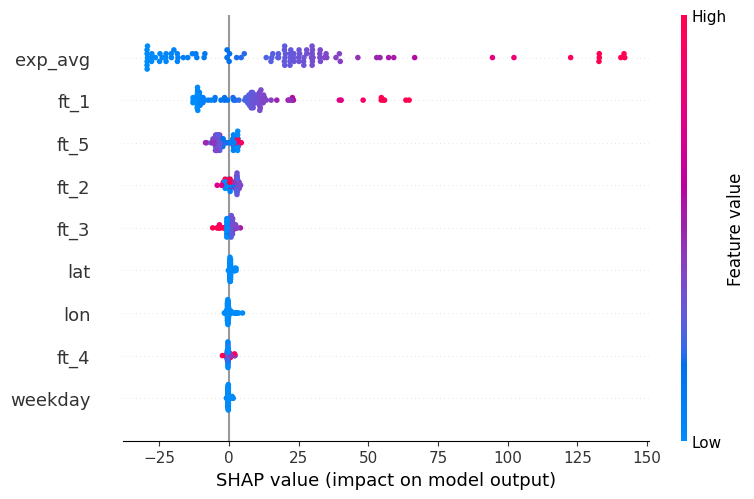

In [32]:
shap.summary_plot(shap_values_xgb, x_test[0:100])

## MLP Feature Importance

Permuting feature  1
Permuting feature  2
Permuting feature  3
Permuting feature  4
Permuting feature  5
Permuting feature  6
Permuting feature  7
Permuting feature  8
Permuting feature  9


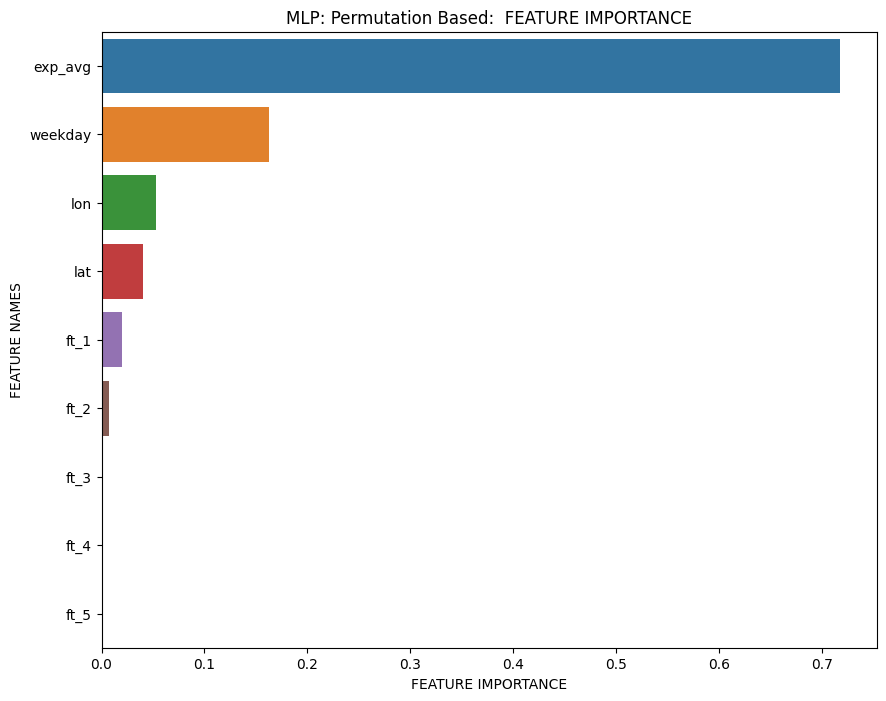

In [33]:
permutation_based_feature_importance_mlp = permutation_based_feature_importance(x_train, y_train, mse_train_mlp, regr_mlp)

plot_feature_importance(permutation_based_feature_importance_mlp,x_train.columns,'MLP: Permutation Based')

## MLP Feature Analysis

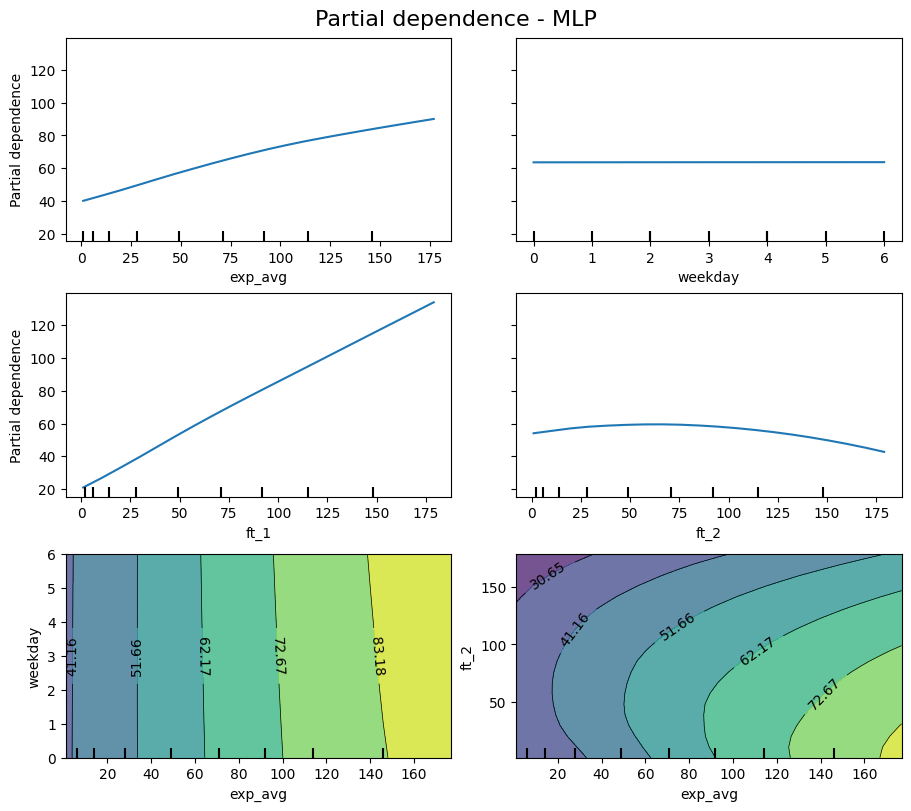

In [34]:
_, ax = plt.subplots(ncols=2, nrows=3, figsize=(9, 8), constrained_layout=True)
display = PartialDependenceDisplay.from_estimator(
    regr_mlp,
    x_train,
    **features_info,
    ax=ax,
    **common_params,
)

_ = display.figure_.suptitle(("Partial dependence - MLP"),fontsize=16)

In [35]:
# for NN, we use 'KernelExplainer', but it's very very slow. So we use 'shap.sample' to sample a subset.
n_samples = 100
explainer_mlp = shap.KernelExplainer(regr_mlp.predict, shap.sample(x_train, n_samples))

In [36]:
shap_values_mlp = explainer_mlp(x_test[0:100])

  0%|          | 0/100 [00:00<?, ?it/s]

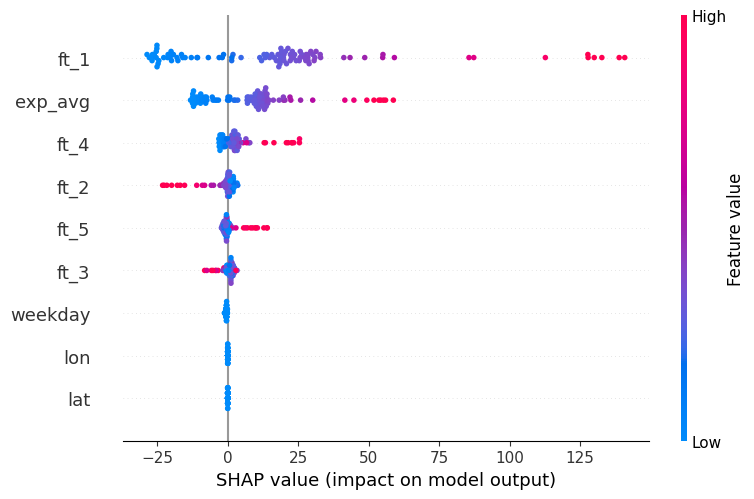

In [37]:
shap.summary_plot(shap_values_mlp, x_test[0:100])

# Local Explainability

## Random Forest SHAP

In [38]:
x_test[:1]

,ft_5,ft_4,ft_3,ft_2,ft_1,lat,lon,weekday,exp_avg
0,235,234,243,277,268,40.732211,-74.003238,0,267


In [39]:
print('Actual:', y_test['target'].iloc[0], 'Random Forest:', y_pred_rf[:1], 'XGBoost:', y_pred_xgb[:1], 'MLP:', y_pred_mlp[:1])

Actual: 247 Random Forest: [256.02234328] XGBoost: [270.08325] MLP: [261.09911755]


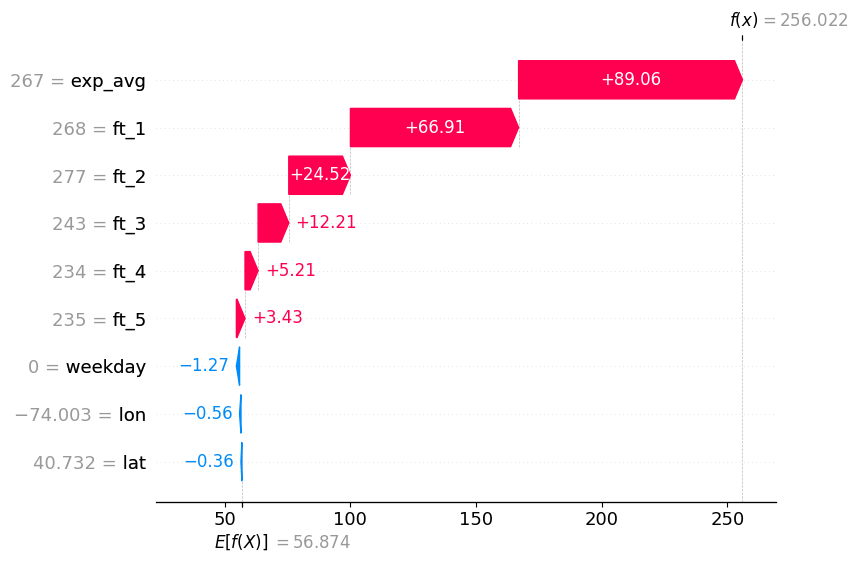

In [40]:
shap.plots.waterfall(shap_values_rf[0])

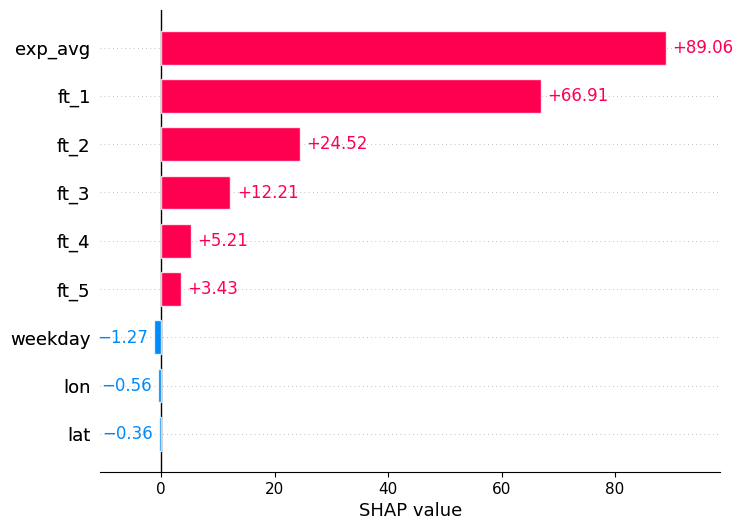

In [41]:
shap.plots.bar(shap_values_rf[0])

### Q12 (5pts): What is the difference between the plots shown by `shap.plots.waterfall` and `shap.plots.bar`?

For both models it is showing the same dataset and out come but there are differences that each plot type focuses on:

shap.plots.waterfall focuses on a single instance's breakdown

shap.plots.bar provides a summary of feature importance across the entire dataset

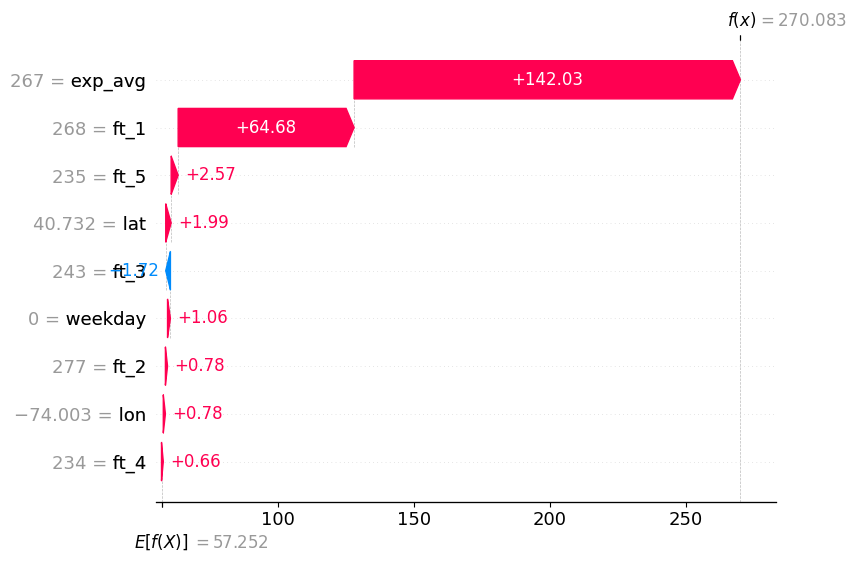

In [42]:
shap.plots.waterfall(shap_values_xgb[0])

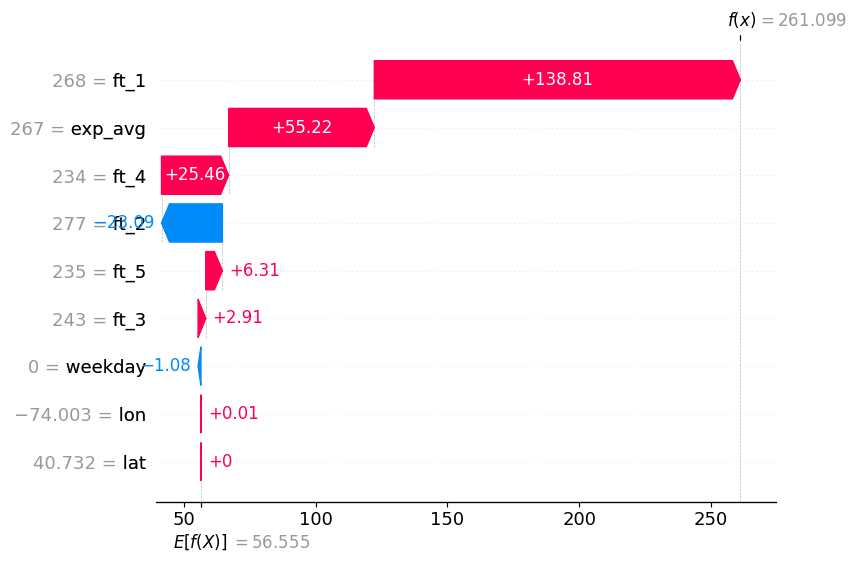

In [43]:
shap.plots.waterfall(shap_values_mlp[0])

### Q13 (5pts): How is it possible that two models (like the XGBoost and MLP models above) can have very similar permutation feature importance but very different SHAP explanations for the same data point?

This makes sense because shap gauges how much contribution each feature plays into the prediction:

so due to their inherent differences between MLP and XGBoost and how the algorithim on how they learn and make predictions it can be different hence why the shap is different for both the models

In [44]:
test_prediction = x_test[0:1].assign(lon=-95.369804,lat=29.760427)
test_prediction

,ft_5,ft_4,ft_3,ft_2,ft_1,lat,lon,weekday,exp_avg
0,235,234,243,277,268,29.760427,-95.369804,0,267


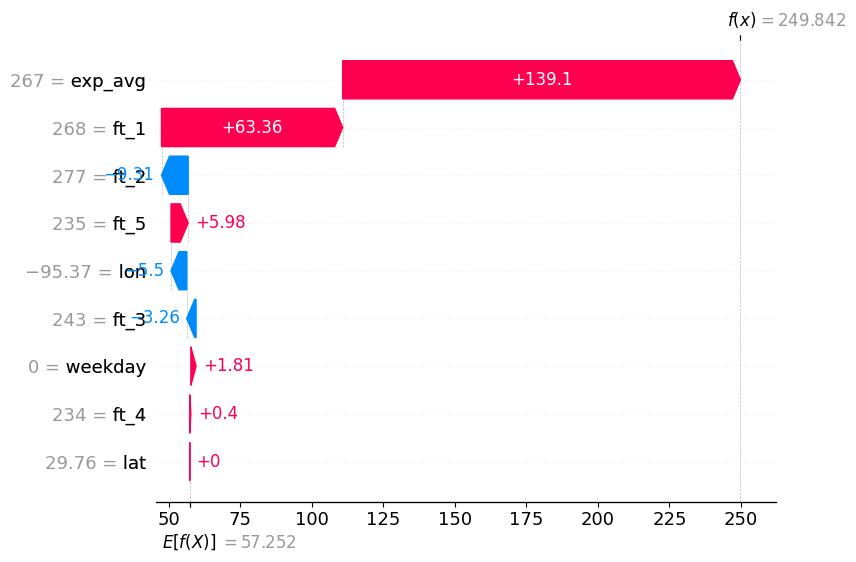

In [45]:
shap_values_test = explainer_xgb(test_prediction)
shap.plots.waterfall(shap_values_test[0])

### Q14 (5pts): Are feature effects independent from each other in our SHAP XGBoost explainer?

No, Feature effects are not entirely independent from each other in a SHAP XGBoost explainer. While SHAP values attempt to approximate the impact of individual features on the model prediction, they take into account the interactions and correlations between features.

### Q15 (5pts): `lon=-95.369804,lat=29.760427` is Houston, TX.  What would a data scientist need to do to create good explanations for this region?

It would depend on what type of model and what you are doing with the data but generally speaking you would want a good dataset(large clean) with good feature engineering and selection and to be using the right model that predicts accurately while using the correct features you would expect to see within the model.